# Milestone 2 project: Political Pope

Neccesary imports

In [84]:
import pandas as pd
import bz2
import json
import re
import math
import pickle
import statistics as stat
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import string
from langdetect import detect # for quotes language filtering
import seaborn as sns # for data visualisation
import fastcluster

# NLP libraries
import nltk, spacy, sklearn
from spacy.lang.en import English

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # useful ?
from nltk.tokenize import TweetTokenizer

from empath import Empath #pip install empath

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# PCA steps
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
lexicon = Empath()

In [8]:
Path = "../data"
df = pd.DataFrame()
for entry in os.scandir(Path):
    if (entry.path.endswith(".pkl") and entry.is_file()):
        file = open(entry,'rb')
        data = pickle.load(file)
        print(len(data))
        df = df.append(data)

84018
48397
46893
95458
46301
10651
102993


In [11]:
df.head()

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers
0,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,0.5395,None,0.3128,Hillary Clinton,0.1477,2015-10-25 14:12:35,1,E,73,359,3
1,But if you talk about why the middle class is ...,Bernie Sanders,0.6011,None,0.3673,Hillary Clinton,0.0141,2015-10-15 10:07:01,1,E,44,227,6
2,"If they destroy you, who is there left?",Bernie Sanders,0.9061,None,0.0939,NaN,NaN,2015-04-15 17:49:00,1,E,8,39,2
3,It would make everybody in America poorer.,Bernie Sanders,0.5619,None,0.277,Ezra Klein,0.0821,2015-07-30 01:49:15,13,E,7,42,5
4,"labor is the source of all wealth,",Bernie Sanders,0.806,None,0.1309,Karl Marx,0.0304,2015-10-14 20:09:23,1,E,7,34,5


## Pre-processing

The first step will be to change the probabilities (type = object) into float numbers to evaluate them properly later on.

In [41]:
new_df = df.copy()

new_df = new_df.astype({'probability': 'float64', 'second_probability': 'float64', 'third_probability': 'float64'})

### A) Speaker probability thresholding

Each quote has a probability assigned by the algorithm that indicates the certainity (or not) it was said from the given speaker. One possible way is to put a threshold of 50% below which a quote will be removed fropm dataset. Here is the logic behind a 50% threshold: if probability >= 0.5, it means we are more confident that the speaker truly said the quote than someone else said it.

Text(0.5, 1.0, 'Pope Francis')

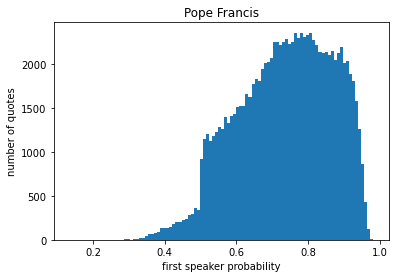

In [42]:
_=plt.hist(new_df.query('speaker == "Pope Francis"').probability,bins=100)
plt.xlabel('first speaker probability')
plt.ylabel('number of quotes')
plt.title('Pope Francis')

Text(0.5, 1.0, 'Elizabteh Warren')

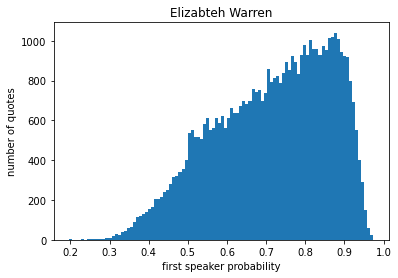

In [43]:
_=plt.hist(new_df.query('speaker == "Elizabeth Warren"').probability,bins=100)
plt.xlabel('first speaker probability')
plt.ylabel('number of quotes')
plt.title('Elizabteh Warren')

In [44]:
# try new method to remove quotes according to more 'robust' threshold
new_df.drop(new_df.query('probability <= 0.5').index, inplace=True)
new_df = new_df.reset_index(drop=True)

### B) NLP basic pre-processing steps

To handle text properly for natural language processing, a set of classical operations must be done:

In [45]:
#1 remove digits
new_df['pre_processed_quote'] = new_df['quote'].astype(str).str.replace('\d+', '', regex=True)
# remove .astype(str), useless ?

In [47]:
#2 remove punctuation
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].apply(lambda x: re.sub(r'[^\w\s]','', x))

In [50]:
#3 remove spaces at the beginning and ending of quotes
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.strip()

In [51]:
#4 remove rows with empty or NaN quotes (so also the ones which only had digits &/or punctuation)
new_df['pre_processed_quote'].replace("", np.nan, inplace=True)
new_df.dropna(subset = ["pre_processed_quote"], inplace=True)

In [52]:
#5 remove capitalization from words
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.lower()

In [57]:
#6 Quotes tokenization (useful for the removal of stop words)
new_df['tokenized_quote'] = new_df['pre_processed_quote'].apply(lambda x: tokenizer.tokenize(x)) #important for features (voc)

In [58]:
#7 Quotes lemmatization to simplify the NLP. Helps to focus on the meaning of the word instead of its variations.
new_df['lemmatized_quote'] = new_df['tokenized_quote'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

# careful ! poor lemmatization (does -> doe, has -> ha etc)

In [61]:
new_df

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers,pre_processed_quote,tokenized_quote,lemmatized_quote
0,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,0.5395,None,0.3128,Hillary Clinton,0.1477,2015-10-25 14:12:35,1,E,73,359,3,it is not now nor has it ever been the gold st...,"[it, is, not, now, nor, has, it, ever, been, t...","[it, is, not, now, nor, ha, it, ever, been, th..."
1,"If they destroy you, who is there left?",Bernie Sanders,0.9061,None,0.0939,NaN,NaN,2015-04-15 17:49:00,1,E,8,39,2,if they destroy you who is there left,"[if, they, destroy, you, who, is, there, left]","[if, they, destroy, you, who, is, there, left]"
2,It would make everybody in America poorer.,Bernie Sanders,0.5619,None,0.2770,Ezra Klein,0.0821,2015-07-30 01:49:15,13,E,7,42,5,it would make everybody in america poorer,"[it, would, make, everybody, in, america, poorer]","[it, would, make, everybody, in, america, poorer]"
3,People should be elected to office based on th...,Bernie Sanders,0.6668,None,0.2898,Ben Carson,0.0222,2015-09-20 21:20:20,18,E,19,103,7,people should be elected to office based on th...,"[people, should, be, elected, to, office, base...","[people, should, be, elected, to, office, base..."
4,That nominee will say that we are going to ove...,Bernie Sanders,0.6267,None,0.3320,Hillary Clinton,0.0413,2015-05-10 20:20:12,1,E,35,220,3,that nominee will say that we are going to ove...,"[that, nominee, will, say, that, we, are, goin...","[that, nominee, will, say, that, we, are, goin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272827,the Gospel of Jesus Christ is the greatest jus...,Pope Francis,0.8534,None,0.1466,NaN,NaN,2020-03-11 15:05:20,1,E,33,165,2,the gospel of jesus christ is the greatest jus...,"[the, gospel, of, jesus, christ, is, the, grea...","[the, gospel, of, jesus, christ, is, the, grea..."
272828,"from the bishop to the foreigner, from the pri...",Pope Francis,0.7182,None,0.2818,NaN,NaN,2020-01-17 16:07:41,1,E,46,278,2,from the bishop to the foreigner from the prie...,"[from, the, bishop, to, the, foreigner, from, ...","[from, the, bishop, to, the, foreigner, from, ..."
272829,"`saw the son coming from afar,' that son who h...",Pope Francis,0.7372,None,0.2628,NaN,NaN,2020-03-20 13:13:06,1,E,20,96,2,saw the son coming from afar that son who had ...,"[saw, the, son, coming, from, afar, that, son,...","[saw, the, son, coming, from, afar, that, son,..."
272830,This prayer of the Angelus today is a little s...,Pope Francis,0.7234,None,0.2766,NaN,NaN,2020-03-08 20:57:39,1,E,28,125,2,this prayer of the angelus today is a little s...,"[this, prayer, of, the, angelus, today, is, a,...","[this, prayer, of, the, angelus, today, is, a,..."


In [62]:
#8 remove stop words
stop_words = stopwords.words('english')
stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)
stop_words.extend([singer.capitalize() for singer in stop_words]) #stop words with capitale
stop_words.extend(list(string.punctuation))

new_df['pre_processed_quote'] = new_df['tokenized_quote'].apply(lambda x: (" ").join([word for word in x if not word in stop_words]))


In [65]:
print((len(df)-len(new_df))/len(df))
print(len(df))
print(len(new_df))

0.37238993262190284
434711
272829


### C) Non-english quotes removal

Quotebank dataset is composed of quotes of different languages. In fact the machinery(find better term) craved on websites of different languages. To perform good NLP and for the sake of comparing what is comparable, we'll remove every quote that isn't considered as english. This task will be done with the NLP language detection library 'langdetect' that supports over 55 different languages.

detect_langs("Otec matka syn.")
[sk:0.572770823327, pl:0.292872522702, cs:0.134356653968]
could be used to solidy quotes selection with p(english) >= 0.8 for example

In [66]:
new_df = new_df.reset_index(drop=True)
index = []

# 30 min !!
for n, quote_ in enumerate(new_df['quote']) :
    value = detect(quote_)
    if value != "en":
        index.append(n)



--- 1851.5020411014557 seconds ---


In [74]:
new_df.drop(index, inplace=True)
new_df = new_df.reset_index(drop=True)

#print("Percentage of non-english quotes that were removed :", round((len(df)-len(new_df))/len(df)*100, 2))

In [77]:
new_df.to_pickle("../data/pre_processed_df.pkl")

## Exploratory analysis

## Features extraction (data processing)

In [150]:
# Extract features
speakers = [['Pope Francis',0],['Hillary Clinton',1],['Bernie Sanders',1],['Elizabeth Warren',1],['Mike Pence',2],['Mitt Romney',2],['Ted Cruz',2]]
all_features = pd.DataFrame()

for s in speakers:
    
    df = new_df[new_df['speaker'].str.match(s[0])]
    
    features_nbr_words = pd.DataFrame(data = {'mean_nbr_words': df['nbr_words'].mean(), 'median_nbr_words': df['nbr_words'].median(), 'std_nbr_words': df['nbr_words'].std()}, index=[0])
    features_nbr_chars = pd.DataFrame({'mean_nbr_words': df['nbr_characters'].mean(), 'median_nbr_words': df['nbr_characters'].median(), 'std_nbr_words': df['nbr_characters'].std()}, index=[0])
    features_nbr_occurences = pd.DataFrame({'mean_nbr_words': df['nbr_occurences'].mean(), 'median_nbr_words': df['nbr_occurences'].median(), 'std_nbr_words': df['nbr_occurences'].std()}, index=[0])
    
    #Feature 'vocabulary richness'
    all_words = pd.DataFrame(df['tokenized_quote'].explode(ignore_index=True)).rename({'tokenized_quote': 'word'}, axis=1)
    unique_words = all_words.value_counts().rename_axis('word').reset_index(name='nbr_occurence')
    feature_voc = pd.DataFrame({'voc_richness': len(unique_words)/len(df)}, index=[0])

    #Features 'lexical fields'
    features_lex_fields = pd.DataFrame([lexicon.analyze(df['pre_processed_quote'].str.cat(sep = ' '), categories = ["money","hate","family","health","dispute","nervousness","government",
                                                          "swearing_terms","suffering","optimism","divine","sexual","fear","business","religion",
                                                         "worship","leader","death","violence","military","war","rage","science","sadness",
                                                         "joy","economics","politics","anger","strength","power","terrorism","poor","pain",
                                                      "philosophy","negative_emotion","competing","law","achievement","contentment",
                                                         "positive_emotion"])])

    features = pd.concat([features_nbr_words, features_nbr_chars, features_nbr_occurences, feature_voc, features_lex_fields, pd.DataFrame([s[1]], columns=["party"])], axis=1)
    all_features = all_features.append(features)
    all_features.rename(index={0: s[0]}, inplace=True)

all_features.to_pickle("../data/all_features.pkl")
all_features


Pope Francis
0
Hillary Clinton
1
Bernie Sanders
1
Elizabeth Warren
1
Mike Pence
2
Mitt Romney
2
Ted Cruz
2


,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_words,median_nbr_words,std_nbr_words,voc_richness,...,poor,pain,philosophy,negative_emotion,competing,law,achievement,contentment,positive_emotion,party
Pope Francis,22.226427,18.0,18.121605,124.517399,99.0,101.617256,6.782749,1.0,35.039717,0.339214,...,5890.0,7084.0,5734.0,11284.0,2217.0,6447.0,5511.0,4906.0,23723.0,0
Hillary Clinton,23.330526,18.0,19.938311,126.784929,96.0,109.443194,7.549297,1.0,34.624723,0.395224,...,4008.0,3491.0,3368.0,12326.0,5900.0,10858.0,7231.0,1403.0,9901.0,1
Bernie Sanders,24.217236,19.0,19.029848,133.819142,107.0,106.496159,5.415862,1.0,23.785522,0.360762,...,7263.0,2904.0,6187.0,12254.0,6701.0,14462.0,7345.0,884.0,8644.0,1
Elizabeth Warren,23.587804,19.0,18.278905,130.363773,105.0,102.087914,5.412948,1.0,22.904973,0.621715,...,3190.0,1170.0,1637.0,7174.0,3584.0,7971.0,2898.0,349.0,4069.0,1
Mike Pence,23.159514,19.0,17.223870,130.658891,107.0,98.283344,10.131981,1.0,56.109529,0.622556,...,1354.0,830.0,1819.0,2663.0,1928.0,5735.0,3778.0,443.0,5633.0,2
Mitt Romney,23.621938,19.0,19.567369,129.131960,100.0,108.765168,7.289903,1.0,29.545952,1.436526,...,405.0,263.0,256.0,976.0,640.0,1221.0,785.0,102.0,1014.0,2
Ted Cruz,23.954587,18.0,20.606223,134.339351,103.0,116.761720,5.610247,1.0,28.321382,0.679614,...,1406.0,1367.0,1889.0,5114.0,2968.0,8460.0,3368.0,384.0,3864.0,2


## PCA

In [158]:
#centrer et normaliser FIND BETTER selection of columns (take all of them except the last one, party)

features = all_features.loc[:, all_features.columns != 'party']
features_with_party = all_features

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(features), columns = features.columns).copy()


nbr_components = min(len(features.columns), len(features))

%matplotlib inline

pca_screeplot = PCA(n_components=nbr_components)
pca_screeplot.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

#percentage variance explaines
ratio = pca_screeplot.explained_variance_ratio_
print('The 2D PCA contains',round((ratio[0]+ratio[1])*100),'% of the information' )
print("")

print ('Component 1 contains',ratio[0]*100,'% of the information' )
print ('Component 2 contains',ratio[1]*100,'% of the information' )
print ('Component 3 contains',ratio[2]*100,'% of the information' )
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2]]))*100,'% of the information has been lost' )
print ('Component 4 contains',ratio[3]*100,'% of the information' )
print ('Component 5 contains', ratio[4]*100,'% of the information' )
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2],ratio[3],ratio[4]]))*100,'% of the information has been lost' )


The 2D PCA contains 83 % of the information

Component 1 contains 54.9774351641619 % of the information
Component 2 contains 27.832904752289767 % of the information
Component 3 contains 8.010883578066617 % of the information
So far, 9.17877650548171 % of the information has been lost
Component 4 contains 5.457731036324076 % of the information
Component 5 contains 2.5911325525154707 % of the information
So far, 1.1299129166421618 % of the information has been lost


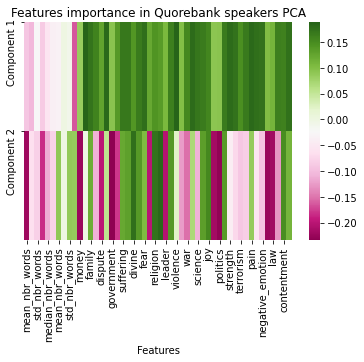

In [160]:
#Interpretation of the components (permet de voir quelle(s) feature(s) sont le plus importantes!)

%matplotlib inline

pca_2d = PCA(n_components=2)
pca_2d.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

map_ = pd.DataFrame(pca_2d.components_,columns=scaled_df.columns)
sns.heatmap(map_,cmap="PiYG")
plt.title("Features importance in Quorebank speakers PCA")
plt.yticks([0,1],['Component 1','Component 2'], fontsize=10)
plt.xlabel('Features')

plt.show()

In [161]:
#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

#3D PCA
PCA_3d = PCA(n_components=3)
PCs_3 = PCA_3d.fit_transform(scaled_df)
res_PCA_3d = pd.DataFrame(data = PCs_3, columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])


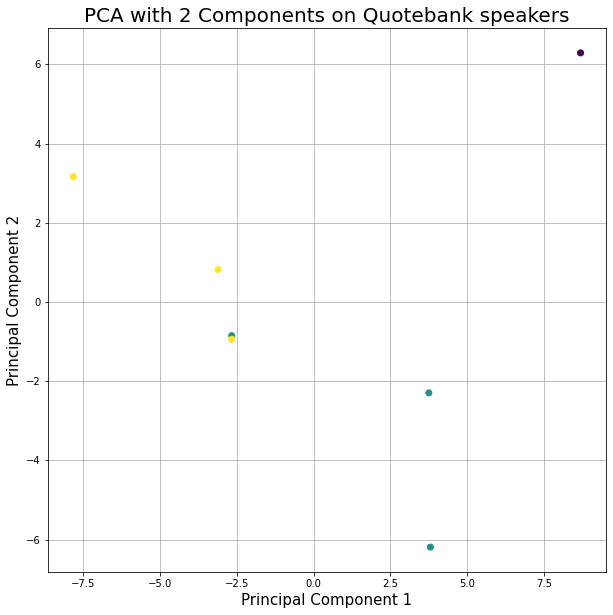

In [163]:
#Visualize results 2D PCA
%matplotlib inline

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  

plt.title("PCA with 2 Components on Quotebank speakers",fontsize=20) 

plt.scatter(res_PCA_2d.loc[:,'Principal component 1'], res_PCA_2d.loc[:,'Principal component 2'], c = all_features['party'])


#Ce bout de code permet de colorer les data points différement en fonction du speaker, 
#je le réadapterai quand on en aura plus qu'un

#targets=[1,2,3] 
#colors=['r','g','b']  

#for target,color in zip(targets,colors):    
#    indicesToKeep = y == target  
#    plt.scatter(EV_df_PCA.loc[indicesToKeep,'principal component 1'],
#            EV_df_PCA.loc[indicesToKeep,'principal component 2'],c=color)
#plt.legend(['sch','rel','con'])

plt.grid()

<IPython.core.display.Javascript object>


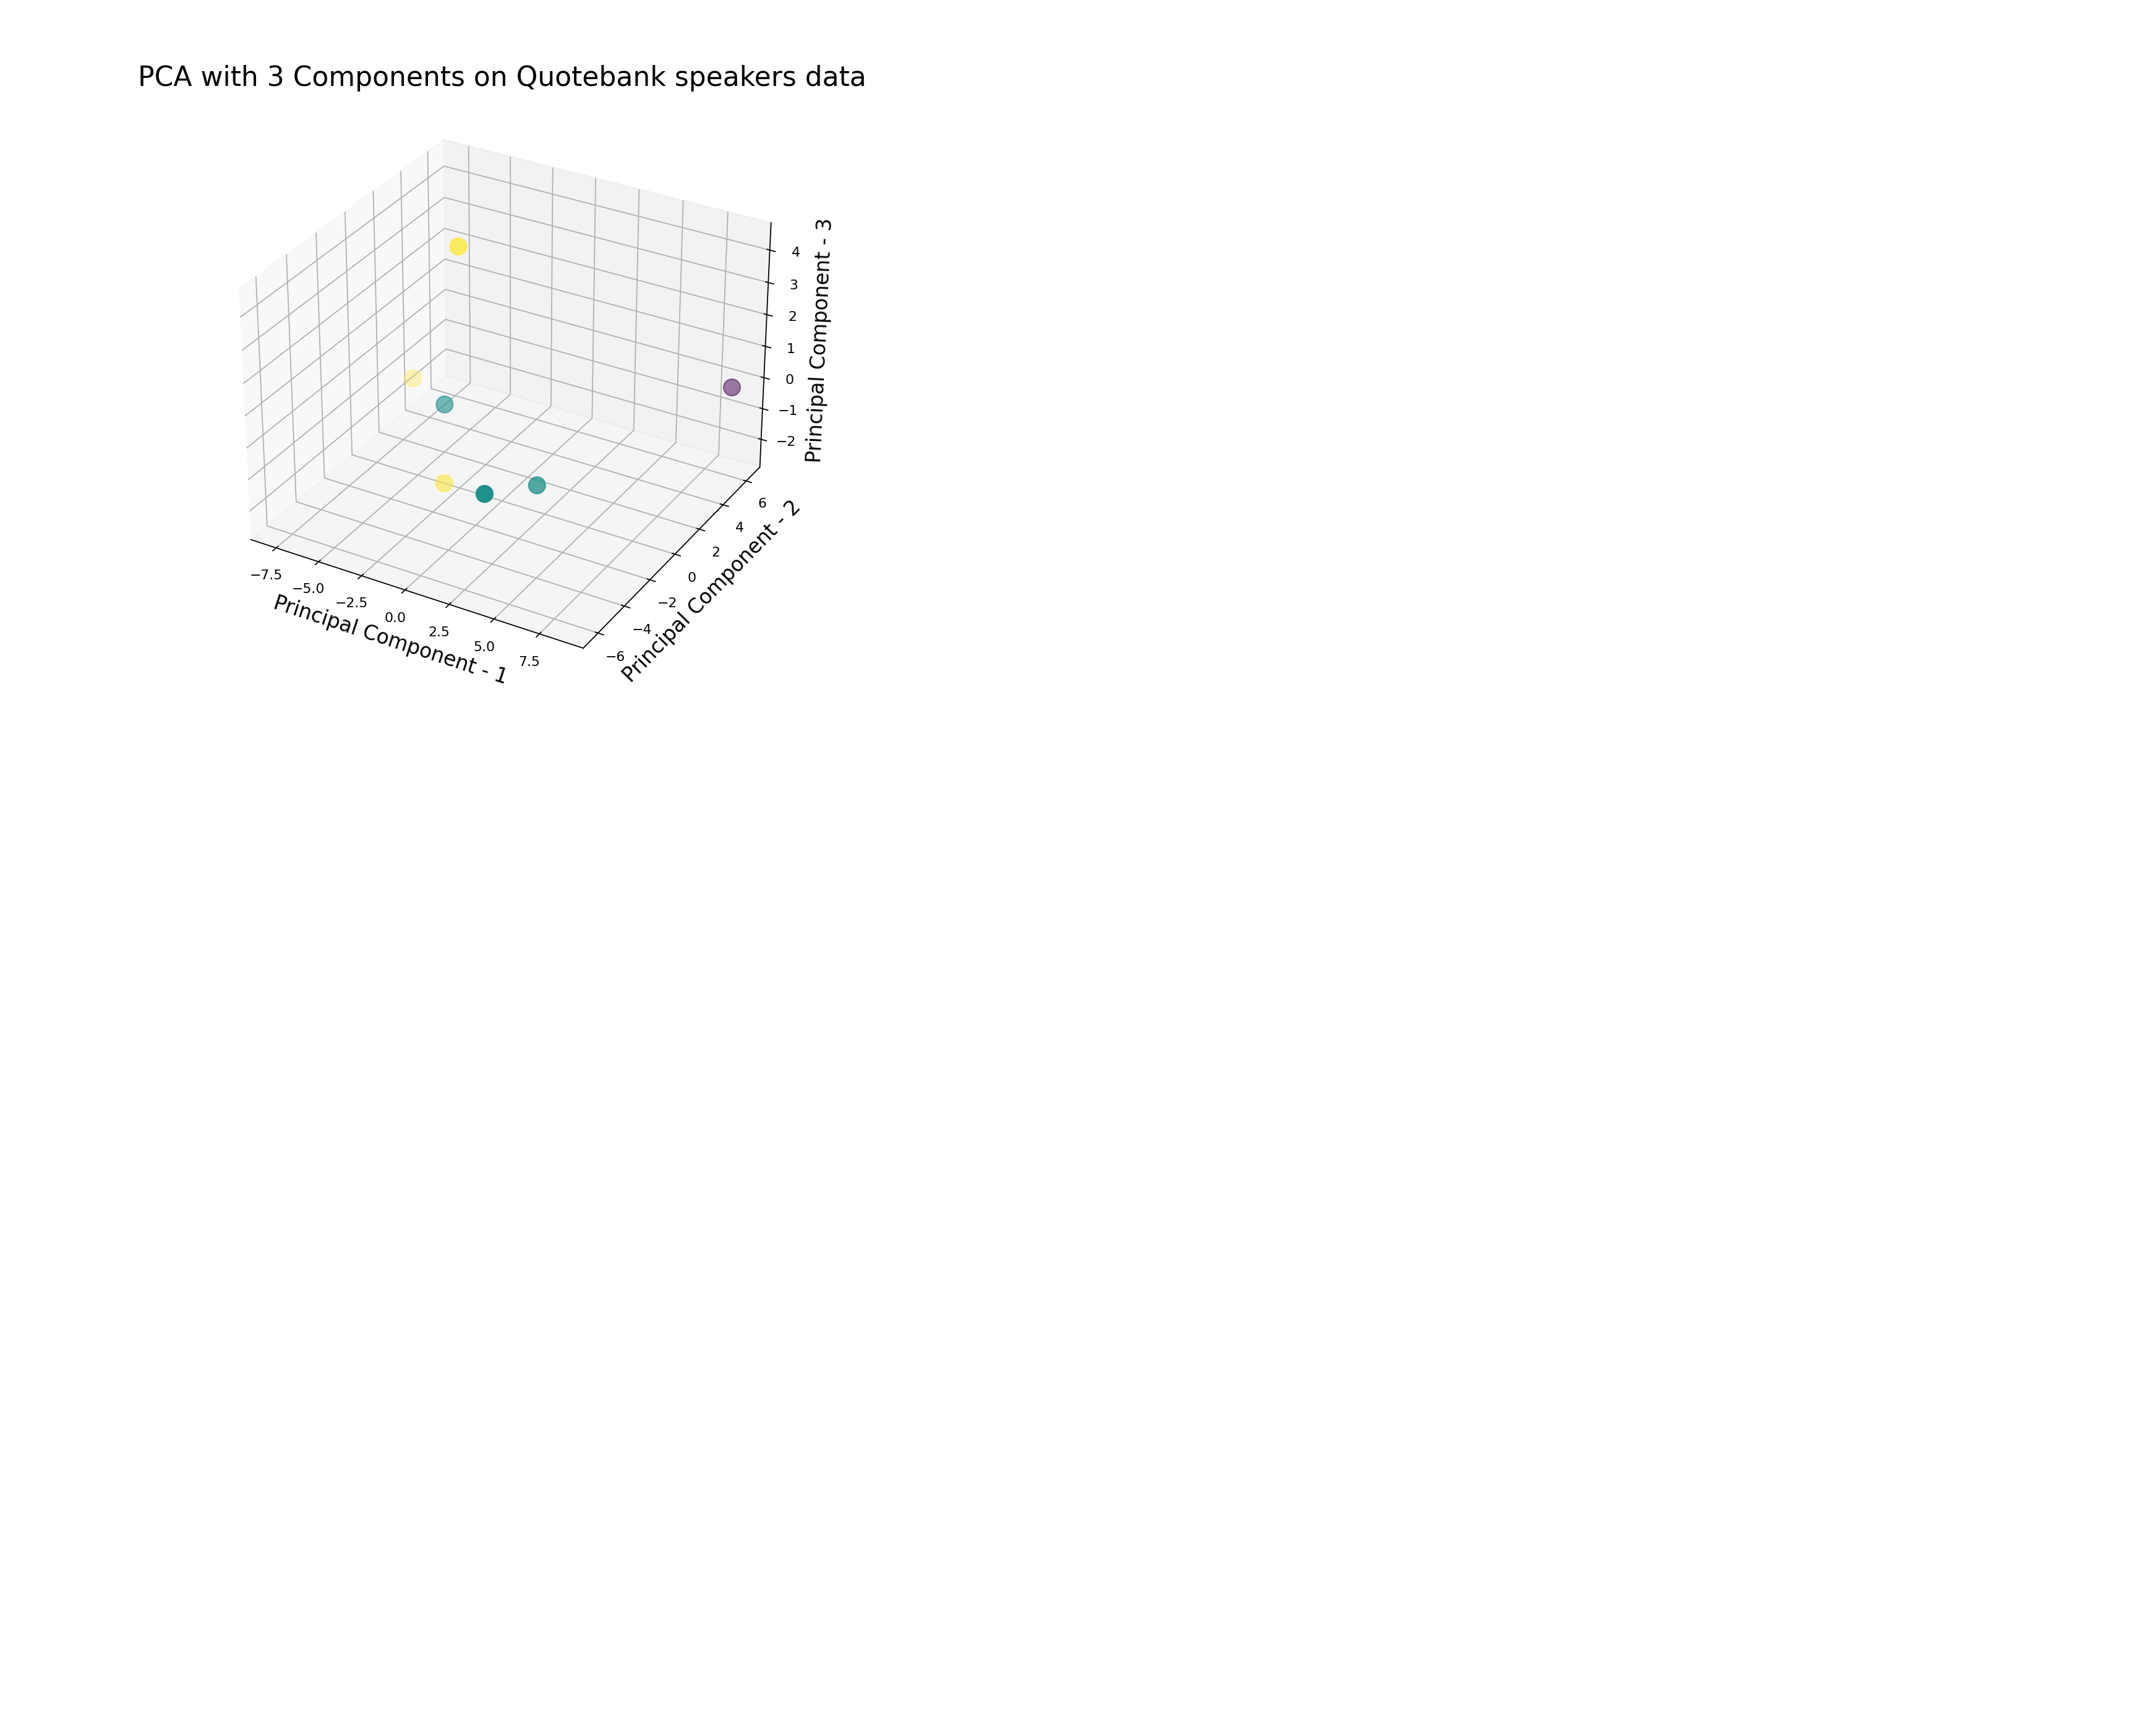

In [166]:
#Visualize results 3D PCA
%matplotlib notebook

plt.figure(figsize=(10,8))

ax = plt.axes(projection="3d")
ax.set_xlabel('Principal Component - 1',fontsize=15)
ax.set_ylabel('Principal Component - 2',fontsize=15)
ax.set_zlabel('Principal Component - 3',fontsize=15)

plt.title("PCA with 3 Components on Quotebank speakers data",fontsize=20)

ax.scatter(res_PCA_3d.loc[:, 'Principal component 1'], res_PCA_3d.loc[:, 'Principal component 2'], res_PCA_3d.loc[:, 'Principal component 3'], s =150, c = all_features['party'])

